In [1]:
import numpy as np
import scipy.io

In [2]:
f = open('scrambled.mat')

In [3]:
for i in range(5):
    f.readline()

In [4]:
m = []

In [5]:
line = f.readline()
while line[1:]!='':
    val = int(line[1:])
    m.append(val)
    line = f.readline()

In [6]:
x = np.array(m)
mat = x.reshape(512,512).T

In [7]:
import matplotlib.pyplot as plt

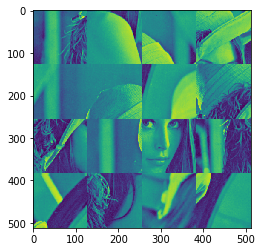

In [17]:
plt.imshow(mat)

In [18]:
x = np.arange(0,4)
y = np.arange(0,4)
np.random.shuffle(x)
np.random.shuffle(y)
x,y

(array([3, 1, 2, 0]), array([0, 1, 3, 2]))

In [19]:
mat[128*x[0]:128*x[0]+128, 128*y[0]:128*y[0]+128]

array([[153, 157, 154, ..., 170, 155, 128],
       [153, 157, 154, ..., 170, 155, 128],
       [153, 157, 154, ..., 170, 155, 128],
       ...,
       [203, 187, 158, ..., 159, 159, 158],
       [180, 156, 148, ..., 158, 159, 158],
       [153, 150, 173, ..., 160, 160, 161]])

In [20]:
class Energy:
    def __init__(self, image):
        self.image = image
        self.height = 4
        self.width = 4

    def getLeftRightEnergy(self, tile):
        i, j = tile
        x1 = 128 * i
        x2 = 128 * (i + 1)
        y = 128 * (j + 1) - 1
        diff = self.image[x1:x2,y] - self.image[x1:x2,y + 1]
        return np.sqrt((diff**2).mean())

    def getUpDownEnergy(self, tile):
        i, j = tile
        y1 = 128 * j
        y2 = 128 * (j + 1)
        x = 128 * (i + 1) - 1
        diff = self.image[x, y1:y2] - self.image[x + 1, y1:y2]
        return np.sqrt((diff**2).mean())

    def getEnergyAround(self, tile):
        i, j = tile
        e = np.zeros(4)
        e[0] = self.getLeftRightEnergy((i,j-1))
        e[1] = self.getLeftRightEnergy((i,j))
        e[2] = self.getUpDownEnergy((i-1,j))
        e[3] = self.getUpDownEnergy((i,j))
        return e.sum()

    def getEnergyAround2Tiles(self, t1, t2):
        return self.getEnergyAround(t1) + self.getEnergyAround(t2)

    def energy(self):
        energy = 0
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                energy += self.getEnergyAround((i, j))
        return energy

    def cheatEnergy(self):                             # for testing purposes only, not used in the algorithm obviously
        return np.linalg.norm(self.image - original)

In [21]:
e = Energy(image = mat)
e.energy()

1035.15508413872

In [22]:
class Proposal:
    # sigma = 20, t=200->5, steps=10**6, final energy value 19.6k, cheat energy 25.3k 
    # sigma = 40, t=200->5, steps=10**6, final energy value 21.6k, cheat energy 37k
    # sigma = 30, t=200->5, steps=3*10**6, final energy value 
    def __init__(self, data, priorityRecomputeRate = 10**3, sigma = 30): 
        self.sigma = sigma
        self.priorityRecomputeRate = priorityRecomputeRate
        self.data = data
        self.counter = 0
        self.height = self.data.height
        self.width = self.data.width
        self.numTiles = (self.height - 2) * (self.width - 2)
        self.indices = [(i,j) for i in range(1, self.height - 1) for j in range(1, self.width - 1)]
        self.computeEnergies()
        self.sortedTiles = []

    def computeEnergies(self):
        #self.sortedTiles = list(map(lambda i,j: Energy(self.data).getEnergyAround((i,j)), (i,j)), self.indices) 

        for index in self.indices:
            e = Energy(self.data).getEnergyAround(index)
            self.sortedTiles.append((e, index))
        self.sortedTiles.sort(reverse=True)

    def get(self):
        self.counter += 1
        if (self.counter % self.priorityRecomputeRate == 0):
            self.counter = 0
            self.computeEnergies()
        i1 = 0
        i2 = 0
        while i1 == i2:
            i1, i2 = np.round(np.clip(np.abs(np.random.normal(0, self.sigma, 2)), 0, self.numTiles - 1)).astype(int)
        _, t1 = self.sortedTiles[i1]
        _, t2 = self.sortedTiles[i2]
        return [t1, t2]


1000
421.83016138674714


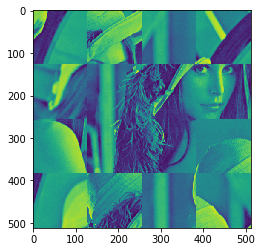

2000
354.5086932555103


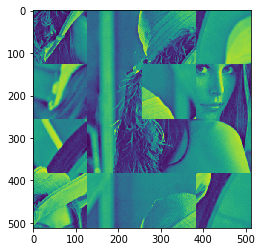

3000
354.5086932555103


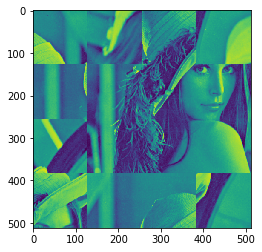

4000
354.5086932555103


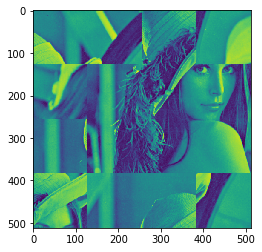

5000
354.5086932555103


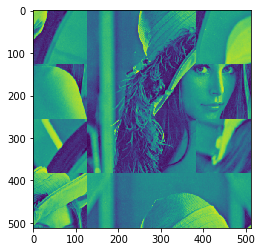

6000
354.5086932555103


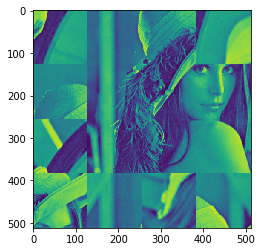

7000
354.5086932555103


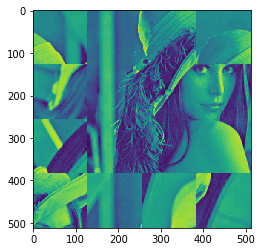

8000
354.5086932555103


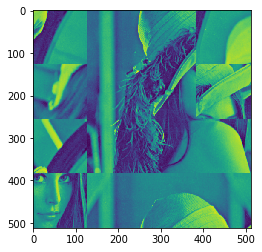

9000
354.5086932555103


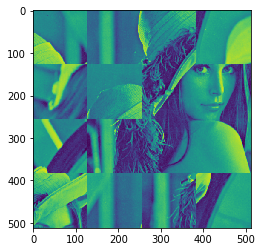

10000
354.5086932555103


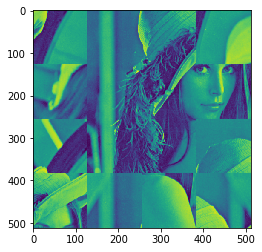

11000
354.5086932555103


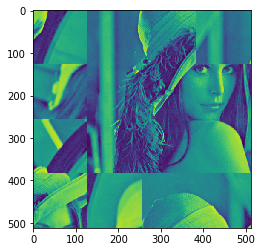

12000
354.5086932555103


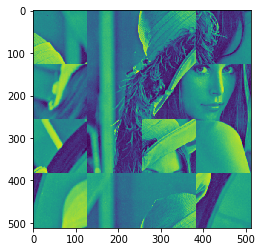

13000
354.5086932555103


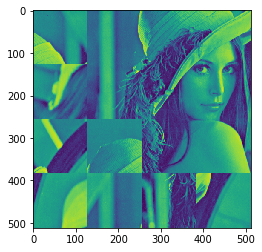

14000
354.5086932555103


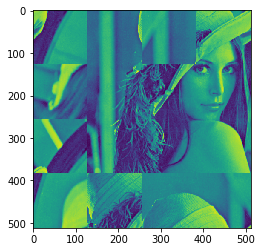

15000
354.5086932555103


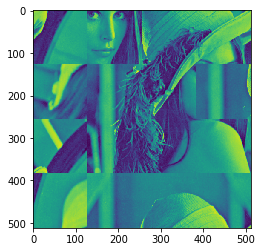

16000
354.5086932555103


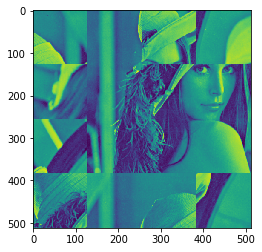

17000
354.5086932555103


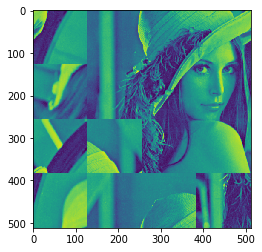

18000
354.5086932555103


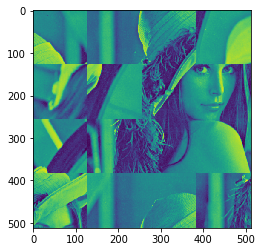

19000
354.5086932555103


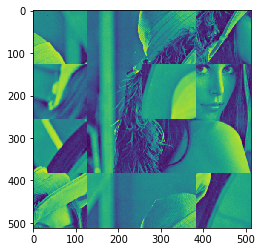

20000
354.5086932555103


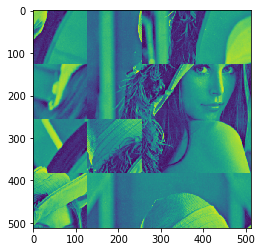

21000
354.5086932555103


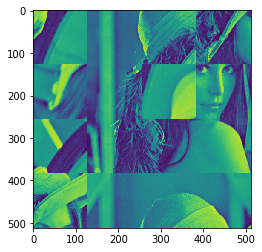

22000
354.5086932555103


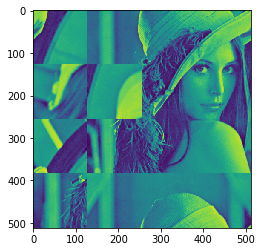

23000
354.5086932555103


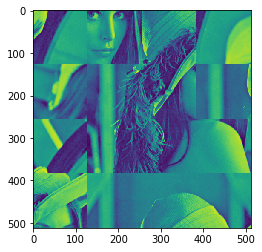

24000
354.5086932555103


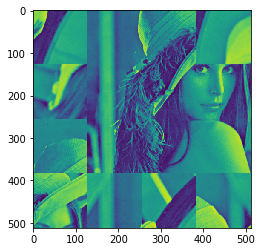

25000
354.5086932555103


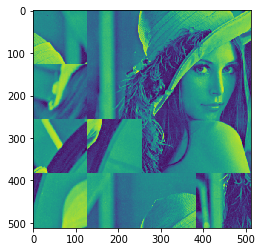

26000
354.5086932555103


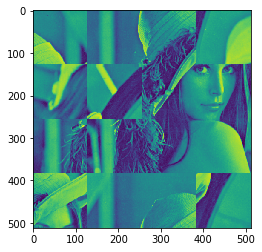

27000
354.5086932555103


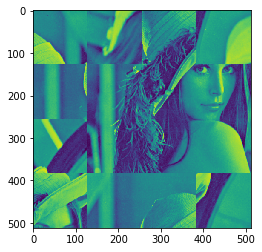

28000
354.5086932555103


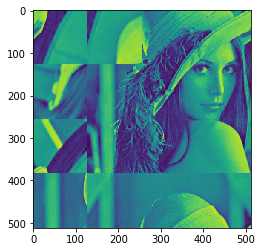

29000
354.5086932555103


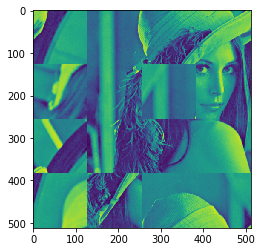

30000
354.5086932555103


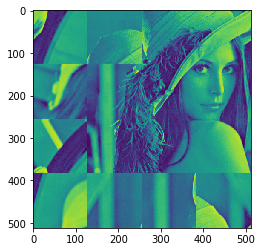

31000
354.5086932555103


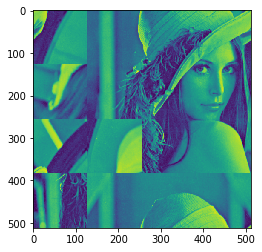

KeyboardInterrupt: 

In [35]:
max_iter = 100000
temp = 1000
stop_temp = 0.00005
decay = 0.995
x = np.arange(0,4)
y = np.arange(0,4)
curr_iter = 0
e = Energy(image = mat)
best_cost = e.energy()
best = mat
cost_list = []

while curr_iter!=max_iter and temp>=0:
    
    new = best.copy()
    np.random.shuffle(x)
    np.random.shuffle(y)
    
    new[128*x[0]:128*x[0]+128, 128*y[0]:128*y[0]+128] = best[128*x[1]:128*x[1]+128, 128*y[1]:128*y[1]+128]
    new[128*x[1]:128*x[1]+128, 128*y[1]:128*y[1]+128] = best[128*x[0]:128*x[0]+128, 128*y[0]:128*y[0]+128]
    
    cost_new = Energy(image=new).energy()
    
    if cost_new < best_cost:
        best = new
        best_cost = cost_new
        
    elif np.random.rand()<np.exp(-abs(best_cost-cost_new)/temp):
        best = new
        best_cost = cost_new
    
    temp = temp*decay
    curr_iter+=1
    cost_list.append(best_cost)
    
    if curr_iter%1000==0:
        print(curr_iter)
        print(best_cost)
        plt.imshow(new)
        plt.show()
    
    

In [ ]:
np.random.rand()

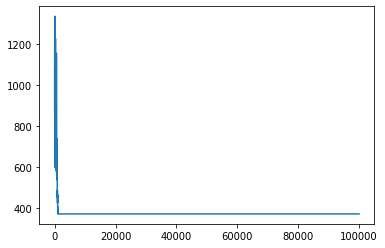

In [32]:
plt.plot(cost_list)

In [34]:
cost_list[-10:]

[373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731,
 373.4751132620731]

1174.5192549983803 995.0


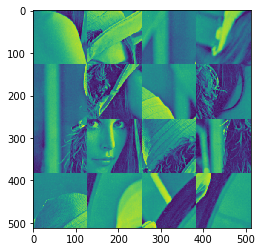

1017.956578812027 990.025


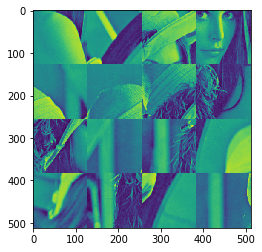

1058.1560312585357 985.074875


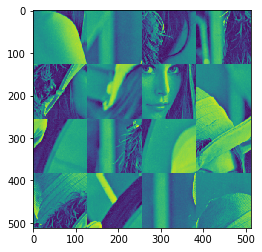

941.4715621777144 980.149500625


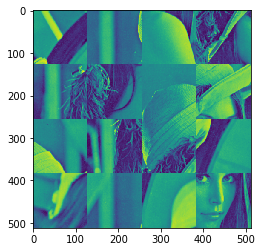

1145.2002718874487 975.248753121875


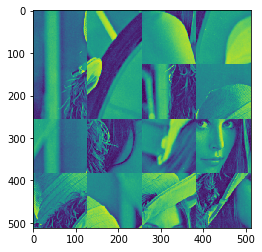

1107.4753235169383 970.3725093562656


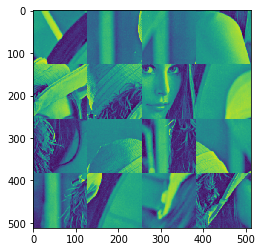

1112.2364694150924 965.5206468094842


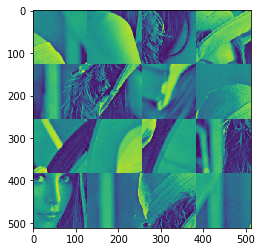

1014.7288837136289 960.6930435754368


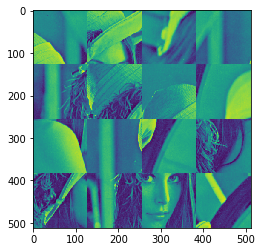

1063.052889364026 955.8895783575597


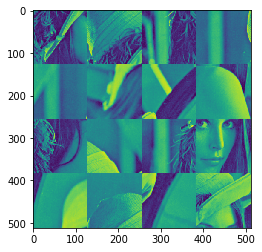

903.2546078149642 951.1101304657719


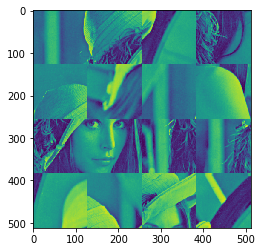

956.8278048087797 946.354579813443


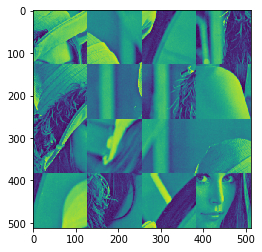

1051.2826841476758 941.6228069143758


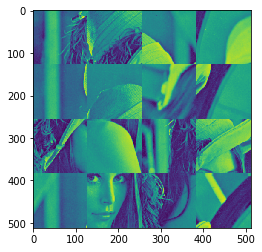

1190.8377344789546 936.914692879804


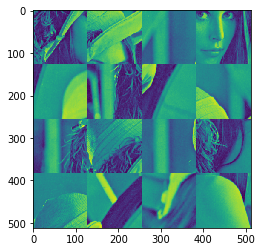

1140.43638748232 932.2301194154049


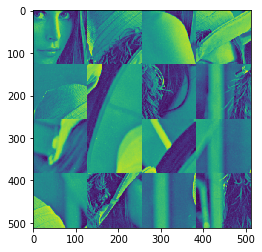

993.1532261408537 927.5689688183279


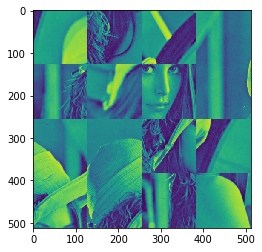

958.1250737113457 922.9311239742362


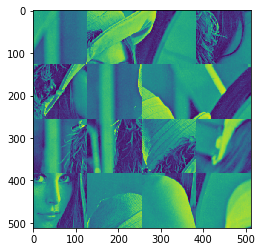

1247.0369034374457 918.316468354365


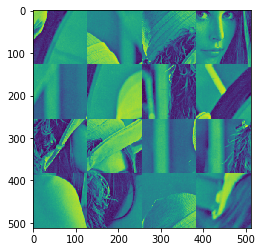

1081.6824668831412 913.7248860125932


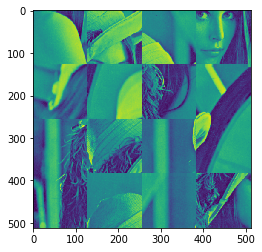

1020.2488287901987 909.1562615825302


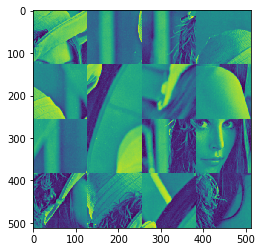

988.5395228538641 904.6104802746175


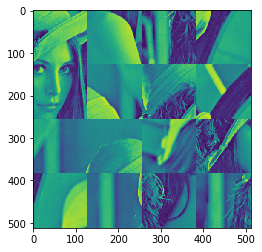

1063.678445537676 900.0874278732445


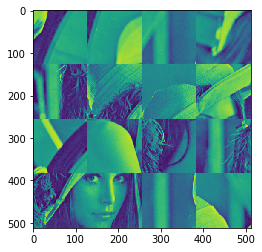

982.1324018920513 895.5869907338782


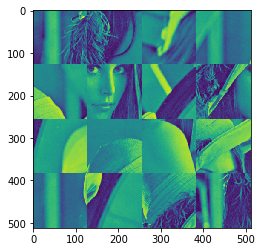

941.2668453572485 891.1090557802088


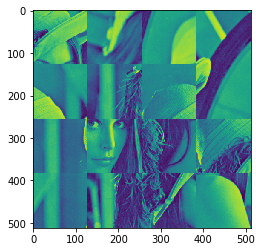

883.5591326525513 886.6535105013078


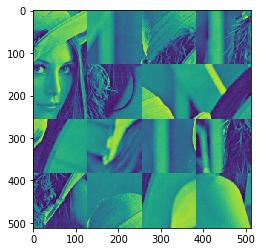

826.2305682765775 882.2202429488012


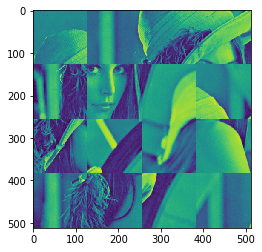

1112.8157006762044 877.8091417340572


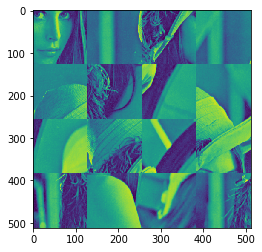

878.4716386373793 873.4200960253869


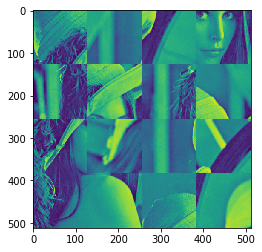

1228.6804613855327 869.0529955452599


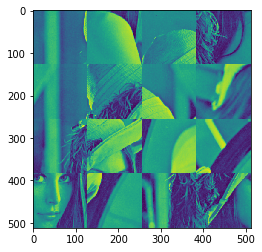

945.9814226320992 864.7077305675336


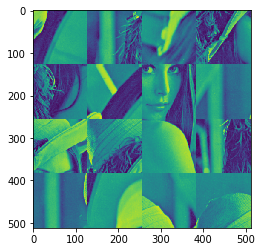

922.1877643564211 860.384191914696


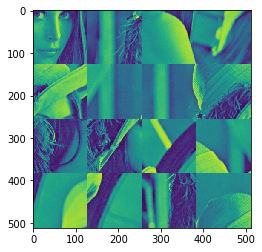

900.5823429032466 856.0822709551225


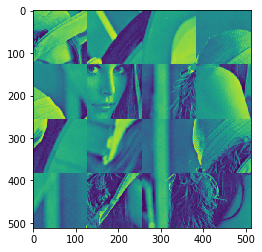

978.3952370075187 851.8018596003468


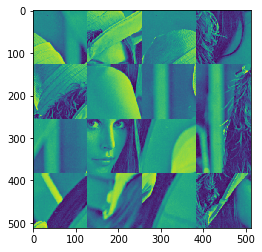

1092.4551775824953 847.5428503023451


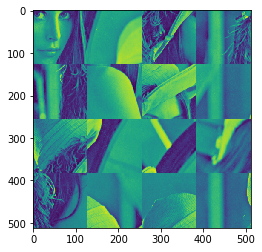

1051.8054640359744 843.3051360508333


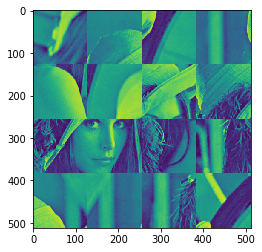

1085.0550512691082 839.0886103705791


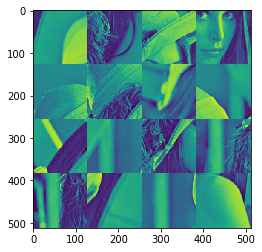

985.2568918449201 834.8931673187262


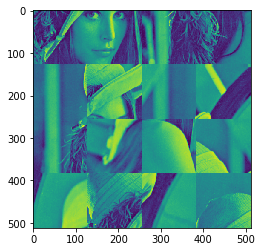

930.7373282164765 830.7187014821326


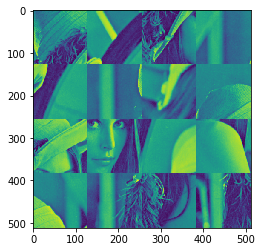

1191.6723206467261 826.565107974722


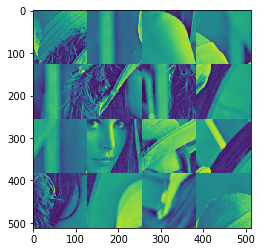

926.625888229414 822.4322824348484


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [24]:
epochs = 500
c = 1000
best = mat
x = np.arange(0,4)
y = np.arange(0,4)

for epoch in range(1,epochs+1):
    
    old = best
    
    for e in range(50):
        new = old.copy()
        cost_old = Energy(image=old).energy()

        np.random.shuffle(x)
        np.random.shuffle(y)
        new[128*x[0]:128*x[0]+128, 128*y[0]:128*y[0]+128] = old[128*x[1]:128*x[1]+128, 128*y[1]:128*y[1]+128]
        new[128*x[1]:128*x[1]+128, 128*y[1]:128*y[1]+128] = old[128*x[0]:128*x[0]+128, 128*y[0]:128*y[0]+128]

        cost_new = Energy(image=new).energy()
        diff = cost_new - cost_old
        if diff:
            old = new

        elif np.random.rand()<np.exp(-diff/c):
            old = new
    
    if Energy(image=old).energy() <  Energy(image=best).energy():
        best=old
    
    c = c*0.995

    print(cost_new, c)
    plt.imshow(new)
    plt.show()


In [72]:
url = 'https://www.ece.rice.edu/~wakin/images/lenaTest2.jpg'
from PIL import Image
import urllib.request

im = Image.open(urllib.request.urlopen(url))

In [73]:
original = np.array(im)

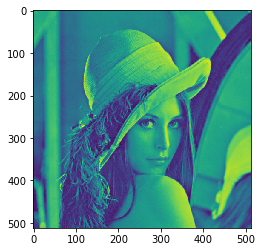

In [74]:
plt.imshow(original)

In [82]:
Energy(image=original).energy()

114.19761565709003

In [50]:
np.random.rand()

0.7680483474967663